## Lección 7: Interpolación de la Curva de Rendimientos por B-Splines

### Objetivos Lección 6: 

1. Conocer y aplicar el método de B-Splines para interpolar la curva de rendimientos. 
2. Analizar un problema de interpolación como un problema de ciencia de datos 

### Ejercicio

Usar la técnica de los B-Splines para obtener la curva cero cupón nominal a partir de una base de datos con los títulos del tesoro vigentes a una fecha.

El precio de un bono se define como el valor presente neto de los flujos asociados al mismo, particularme si los traemos a valor presente usando factores de descuento: 

$ P_{k} = \sum_{t}{d(t)f_{k, t}}$

Donde $P_{k}$ es el precio del bono k, $f_{k,t}$ corresponde al flujo asociado al bono k en el periodo t y $d_{t}$ es el factor de descuento. Se busca entonces encontrar los factores de descuento en distintos periodos de tiempo y así poder construir la curva de rendimientos:

$d(t) = \sum_{n}{a_i g_{i}(t)}$

Donde las funciones $g(i)$ son las funciones de interpolación que vamos a construir y $a_{i}$, son los términos que ponderarán el peso que tendra cada función en la formación del factor de descuento.

Reagrupando la expresión del precio de los bonos:

$ P_{k} = \sum_{t}{f_{k, t}\sum_{n}{a_i g_{i}(t)}}$

$ P_{k} = \sum_{n}{a_{i}\sum_{t}{f_{k, t} g_{i}(t)}}$

Si denominamos el producto $\sum_{t}{f_{k, t} g_{i}(t)}$ (el cuál lo podemos computar ya que contamos tanto con las funciones $g_{i}$ que definimos como con con los flujos que promete cada bono $f_{k,t}$) '$x_{i}$' vemos que este es un problema típico de regresión lineal. 

$ P_{k} = \beta_{i}x_{1,k}+...+\beta_{n}x_{n,k}+\epsilon_{k}$

Obtenidos los coeficientes de a, podemos obtener los factores de descuento ($d_{t}$) y por tanto la curva cero cupón. 

Los pasos de cara a la programación en Python son entonces: 

1. Obtener el dataframe con los flujos de los bonos. 

Primero debemos importar las librerías necesarias, definimos un punto porcentual y creamos una tabla con los bonos. La tabla tiene cinco columnas: 
1) "Ticker" El 'Ticker' del bono. 
2) "Descripción" Una breve 'descripción' del bono.  
3) "Emisión" La fecha de Emisión del bono.
4) "Vecimiento" La fecha de vencimiento del bono.
5) "Cupón" El cupón expresado en términos nominales anuales pero con pago en periodicidad semestrales 
6) "Precio Sucio" del bono.

Precio Sucio = Precio del Bono + Intereses Causados

Intereses Causados = FV*(c/# Pagos al año)*(Días desde el último pago/ Periodo de los Pagos) 

In [76]:
import numpy as np
import pandas as pd
import math
from pandas.tseries.offsets import DateOffset
from librerias.splines import bspline, B 

pp =0.01
df = pd.read_csv('Datos\\'+"datos_tesoros.csv", encoding ='utf-8', sep = ";")
df

,Ticker,Descripción,Emisión,Vencimiento,Cupón,Precio Sucio
0,9128285B Govt,United States Treasury Note/Bond,1/10/2018,30/09/2020,2.750,99.789062
1,9128285A Govt,United States Treasury Note/Bond,17/09/2018,15/09/2021,2.750,99.515625
2,9128284X Govt,United States Treasury Note/Bond,31/08/2018,31/08/2023,2.750,99.035156
3,9128284Y Govt,United States Treasury Note/Bond,31/08/2018,31/08/2020,2.625,99.585938
4,9128284Z Govt,United States Treasury Note/Bond,31/08/2018,31/08/2025,2.750,98.101562
...,...,...,...,...,...,...
305,912810EC Govt,United States Treasury Note/Bond,15/02/1989,15/02/2019,8.875,101.886719
306,912810EB Govt,United States Treasury Note/Bond,22/11/1988,15/11/2018,9.000,100.304688
307,9128285F Govt,United States Treasury Note/Bond,15/10/2018,15/10/2021,2.875,99.855469
308,9128285D Govt,United States Treasury Note/Bond,1/10/2018,30/09/2023,2.875,99.531250


Lo indexamos según su vencimiento y lo ordenamos cronológicamente.

In [77]:
df.index = pd.to_datetime(df['Vencimiento'], format = "%d/%m/%Y")
df = df.sort_index()
df

,Ticker,Descripción,Emisión,Vencimiento,Cupón,Precio Sucio
Vencimiento,,,,,,
2018-11-15,912828M6 Govt,United States Treasury Note/Bond,16/11/2015,15/11/2018,1.250,99.968750
2018-11-15,912810EB Govt,United States Treasury Note/Bond,22/11/1988,15/11/2018,9.000,100.304688
2018-11-15,912828JR Govt,United States Treasury Note/Bond,17/11/2008,15/11/2018,3.750,100.058594
2018-11-30,912828RT Govt,United States Treasury Note/Bond,30/11/2011,30/11/2018,1.375,99.933594
2018-11-30,912828A3 Govt,United States Treasury Note/Bond,2/12/2013,30/11/2018,1.250,99.921875
...,...,...,...,...,...,...
2047-08-15,912810RY Govt,United States Treasury Note/Bond,15/08/2017,15/08/2047,2.750,88.195312
2047-11-15,912810RZ Govt,United States Treasury Note/Bond,15/11/2017,15/11/2047,2.750,88.132812
2048-02-15,912810SA Govt,United States Treasury Note/Bond,15/02/2018,15/02/2048,3.000,92.695312


Definimos la fecha de valoración. Debemos asegurarnos que los bonos venzan despúes de esta.

In [78]:
fecha_valoracion = "31/10/2018"

In [79]:
df = df[df.index>fecha_valoracion]
df['FV'] = 100
df['Cupón'] = df['Cupón']*pp

Haremos una copia de esta tabla para poder hacerle ciertos cambios sin necesidad de alterar la original:

In [80]:
copia_df = df.copy(deep=True)

A esta copia le agregaremos un bono ficitio que refleje el hecho de que el factor de descuento hoy es de 1 (un peso hoy vale un peso hoy).

In [81]:
bono_juguete = pd.DataFrame({'Ticker': 'USTN','Descripción':'Matured Bond','Emisión':fecha_valoracion,'Vencimiento':fecha_valoracion,
	'Cupón':'0','Precio Sucio':	'100.0','FV':100.0},index=[0])

copia_df = pd.concat([bono_juguete,copia_df]).reset_index(drop=True) # se coloca de primero

In [82]:
copia_df.index = pd.to_datetime(copia_df['Vencimiento'], format = "%d/%m/%Y") # Le aplicamos los mismos indices del df original
copia_df

,Ticker,Descripción,Emisión,Vencimiento,Cupón,Precio Sucio,FV
Vencimiento,,,,,,,
2018-10-31,USTN,Matured Bond,31/10/2018,31/10/2018,0,100.0,100.0
2018-11-15,912828M6 Govt,United States Treasury Note/Bond,16/11/2015,15/11/2018,0.0125,99.96875,100.0
2018-11-15,912810EB Govt,United States Treasury Note/Bond,22/11/1988,15/11/2018,0.09,100.304688,100.0
2018-11-15,912828JR Govt,United States Treasury Note/Bond,17/11/2008,15/11/2018,0.0375,100.058594,100.0
2018-11-30,912828RT Govt,United States Treasury Note/Bond,30/11/2011,30/11/2018,0.01375,99.933594,100.0
...,...,...,...,...,...,...,...
2047-08-15,912810RY Govt,United States Treasury Note/Bond,15/08/2017,15/08/2047,0.0275,88.195312,100.0
2047-11-15,912810RZ Govt,United States Treasury Note/Bond,15/11/2017,15/11/2047,0.0275,88.132812,100.0
2048-02-15,912810SA Govt,United States Treasury Note/Bond,15/02/2018,15/02/2048,0.03,92.695312,100.0


In [83]:
fecha_valoracion = pd.to_datetime(fecha_valoracion, format = "%d/%m/%Y")
fecha_valoracion

Timestamp('2018-10-31 00:00:00')

### Proyección de Flujos de Caja:

Definimos los periodos y creamos una nueva tabla donde estarán los bonos y las fechas donde se pagarán

In [84]:
periodos = (df.index.max()-fecha_valoracion) #Tomamos la fecha más lejana y vemos su diferencia con la fecha donde valoramos
periodos

Timedelta('10881 days 00:00:00')

Conseguimos el número de pagos tomando la fecha más lejana de referencia y le restamos la fecha de valoración,  esto lo dividimos por 182.5 lo que equivale a medio año en días, lo cual es nuestra frecuencia.

In [85]:
periodos = (df.index.max()-fecha_valoracion) 
periodos = math.ceil(periodos.days/182.5)
flujos = pd.DataFrame(data = [100], index = [fecha_valoracion], columns= ['bono0'])

In [86]:
for i in range(len(df)): 
    date_range = pd.bdate_range(end= df.index[i], periods = periodos, freq = pd.DateOffset(months=6), inclusive ='right') 
    date_range = date_range[date_range >= fecha_valoracion]
    serie1 = pd.Series([df['FV'].iloc[i]*df['Cupón'].iloc[i]/2]*(len(date_range)-1)+[df['FV'].iloc[i]*(1+df['Cupón'].iloc[i]/2)], index = date_range, name = 'bono' + str(i+1))
    flujos = pd.concat([flujos, serie1], axis = 1)
    flujos

Así como hicimos antes, creamos una copia de flujos, esto nos servirá para hacer cálculos más tarde.

In [87]:
copia_flujos = flujos.copy(deep=True)

Remplazamos las casillas vacías de flujos por ceros

In [88]:
flujos = flujos.fillna(0)
flujos.T

,2018-10-31,2018-11-15,2018-11-30,2018-12-15,2018-12-30,2019-01-15,2019-01-31,2019-02-15,2019-02-28,2019-03-15,...,2046-05-15,2046-08-15,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15
bono0,100.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0,0.0000,0.0
bono1,0.0,100.6250,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0,0.0000,0.0
bono2,0.0,104.5000,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0,0.0000,0.0
bono3,0.0,101.8750,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0,0.0000,0.0
bono4,0.0,0.0000,100.6875,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bono306,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1.375,0.0,0.0,...,0.0000,1.375,0.0000,1.375,0.0000,101.375,0.0000,0.0,0.0000,0.0
bono307,0.0,1.3750,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,1.3750,0.000,1.3750,0.000,1.3750,0.000,101.3750,0.0,0.0000,0.0
bono308,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1.500,0.0,0.0,...,0.0000,1.500,0.0000,1.500,0.0000,1.500,0.0000,101.5,0.0000,0.0
bono309,0.0,1.5625,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,1.5625,0.000,1.5625,0.000,1.5625,0.000,1.5625,0.0,101.5625,0.0


Calculamos los bonos que han vencido para cada fecha. Para ello verificamos cuales flujos de caja ya estan incluyendo el principal del bono.

In [89]:
flujos.loc[:,'vencidos'] = flujos[flujos >= 100].count(axis = 1).cumsum()

Y contamos los días transcurridos a la fecha de evaluación según cada fila.

In [90]:
flujos.loc[:,'dias'] = (flujos.index - flujos.index[0]).days
flujos.T

,2018-10-31,2018-11-15,2018-11-30,2018-12-15,2018-12-30,2019-01-15,2019-01-31,2019-02-15,2019-02-28,2019-03-15,...,2046-05-15,2046-08-15,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15
bono0,100.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0
bono1,0.0,100.6250,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0
bono2,0.0,104.5000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0
bono3,0.0,101.8750,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0
bono4,0.0,0.0000,100.6875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bono308,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1.5,0.0,0.0,...,0.0000,1.5,0.0000,1.5,0.0000,1.5,0.0000,101.5,0.0000,0.0
bono309,0.0,1.5625,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5625,0.0,1.5625,0.0,1.5625,0.0,1.5625,0.0,101.5625,0.0
bono310,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1.5,0.0,0.0,...,0.0000,1.5,0.0000,1.5,0.0000,1.5,0.0000,1.5,0.0000,101.5
vencidos,1.0,4.0000,7.0000,8.0,11.0,12.0,15.0,18.0,21.0,22.0,...,302.0000,303.0,304.0000,305.0,306.0000,307.0,308.0000,309.0,310.0000,311.0


### Número de splines

A la hora de interpolar se definen algunos parámetros, entre ellos cuantos splines serán usados. Se busca además que el número de vencimientos entre los nodos sea el mismo. 

In [91]:
num_splines = 8
num_bonos = (len(flujos.columns)-2)  # Se resta 2 al número de columnas de flujos ya que descontamos la columna 'dias' y 'vencidos', 
num_bonos_nodo = num_bonos/ 5 #(num_splines - Grado de la Interpolación): Deseamos que halla al menos Cuatro funciones B-Splines por nodo. 

In [92]:
num_bonos/ 5

62.2

In [93]:
index =  flujos[flujos['vencidos'] >= num_bonos_nodo].index.values[0] #Da el indice donde se cumple por primera vez la condición  
#de que haya al menos el promedio de bonos por nodo. Esto es una fecha
aux = flujos.index.get_loc(index)  # Dice que posición en números cardinales es ese indice

Definimos tambien los valores iniciales para iterar

In [94]:
value1 = 0#-3*v
value2 = 0#-2*v
value3 = 0#-1*v
value4 = 0
value5 = (flujos.loc[:,'dias'].iloc[aux-1] + flujos.loc[:,'dias'].iloc[aux-1])/2 #418

In [95]:
#Creamos listas que serán usadas como columnas más tarde
valores1 = [value1]
valores2 = [value2]
valores3 = [value3]
valores4 = [value4]
valores5 = [value5]
valoresAux = [aux]

In [96]:
for n in range(num_splines+1):
    #Los valores nuevos se basan en los anteriores:
    aux_viejo = aux
    value1 = value2
    value2 = value3
    value3 = value4
    value4 = value5
    # Si el producto que evaluamos supera el número de bonos que tenemos, 
    # le sumamos 10000 al valor 5 o simplemente tomamos el último indice

    if num_bonos_nodo *( n+2 ) >= num_bonos:
        aux = float(flujos.shape[0]) # cantidad de fechas
        if aux == aux_viejo:
            value5 += 1
        else:
            aux_anterior = int(aux - 1)
            value5 =  flujos.loc[:,'dias'].iloc[aux_anterior]

    #En caso contrario 
    else:
        index = flujos[flujos['vencidos'] >=  num_bonos_nodo *( n+2 )].index.values[0]
        aux = flujos.index.get_loc(index)
        value5 =  (flujos.loc[:,'dias'].iloc[int(aux-1)] + flujos['dias'].iloc[int(aux)])/2


    valores1.append(value1)
    valores2.append(value2)
    valores3.append(value3)
    valores4.append(value4)
    valores5.append(value5)
    valoresAux.append(aux)

Despues de las iteraciones se tienen los siguientes resultados:

In [97]:
valores = pd.DataFrame({'Valor1':valores1,'Valor2':valores2,'Valor3':valores3,'Valor4':valores4,'Valor5':valores5, 'Aux':valoresAux})
valores = valores.iloc[:8,:]
valores

,Valor1,Valor2,Valor3,Valor4,Valor5,Aux
0,0.0,0.0,0.0,0.0,410.0,28.0
1,0.0,0.0,0.0,410.0,873.5,58.0
2,0.0,0.0,410.0,873.5,1537.0,92.0
3,0.0,410.0,873.5,1537.0,2799.0,139.0
4,410.0,873.5,1537.0,2799.0,10881.0,228.0
5,873.5,1537.0,2799.0,10881.0,10882.0,228.0
6,1537.0,2799.0,10881.0,10882.0,10883.0,228.0
7,2799.0,10881.0,10882.0,10883.0,10884.0,228.0


Ahora con los datos hallados y las funciones definidas podemos evaluarlas para conseguir un arreglo de splines según fecha. 

Con respecto a la función Bspline hay que tener en cuenta varias cosas: Para hallar una interpolación de grado k = 3 es necesario tener al menos k + 1 = 4 coeficientes, por lo que es necesario, gracias a la forma que se define n, t y k que n >= k + 1 = 4, lo cual implica que t >= 2 ( k + 1 ) = 2 * 4 = 8, recordemos que la variable t son los nodos. Esto puede presentar un problema considerando que manejamos solo 5 valores pero 8 son requeridos en los nodos, del mismo modo con los coeficientes donde conocemos 1 (se deinirá en el código a continuación) pero 4 son requeridos. Una solución practica es rellenar los valores faltantes con 0.

In [98]:
diccionarioAux = dict() # almacenamiento temporal
grado_interpolacion = 3

for i in range(num_splines): # Vamos recorriendo cada fila de la tabla de valores
    tabla = []
    for j in range(int(flujos.shape[0])): # Recorremos cada fecha de pago de bono
        # Los valores de la tabla que hallamos antes
        v0 = valores.iloc[i,0]   
        v1 = valores.iloc[i,1]
        v2 = valores.iloc[i,2]
        v3 = valores.iloc[i,3]
        v4 = valores.iloc[i,4]
        # Nos dice los días acumulados según la fecha en la que estamos
        dte = flujos.iloc[j][-1] 
        nodos = [v0, v1, v2, v3, v4] 
        spl = B(dte, 3, 0, nodos)
        #spl = bspline(dte, nodos, coeficientes,grado_interpolacion)
        tabla.append( spl )

    diccionarioAux['spline_' + str(i)] = tabla #Crea una lista por cada spline en nuestro almacenamiento temporal

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_46476\1693489727.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dte = flujos.iloc[j][-1]


In [99]:
splines = pd.DataFrame(diccionarioAux) # Creamos la matriz de splines según la fecha
splines.index = flujos.index
splines.T

,2018-10-31,2018-11-15,2018-11-30,2018-12-15,2018-12-30,2019-01-15,2019-01-31,2019-02-15,2019-02-28,2019-03-15,...,2046-05-15,2046-08-15,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15
spline_0,1.0,0.894210,0.796158,0.705549,0.622089,0.540615,0.466584,0.403623,0.353869,0.301749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
spline_1,0.0,0.103939,0.196573,0.278400,0.349916,0.415394,0.470308,0.512730,0.542798,0.570206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
spline_2,0.0,0.001845,0.007220,0.015885,0.027602,0.043194,0.061694,0.081421,0.100194,0.123575,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
spline_3,0.0,0.000006,0.000049,0.000166,0.000392,0.000797,0.001415,0.002226,0.003139,0.004470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
spline_4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000738,0.000517,0.000345,0.000217,0.000127,0.000065,0.000027,0.000008,0.000001,0.000000e+00
spline_5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.024493,0.019542,0.015100,0.011189,0.007929,0.005120,0.002903,0.001296,0.000336,1.323878e-08
spline_6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250479,0.227762,0.203779,0.178507,0.152811,0.124936,0.095703,0.065090,0.033784,3.710749e-04
spline_7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.724290,0.752180,0.780776,0.810088,0.839133,0.869879,0.901367,0.933606,0.965879,9.996289e-01


Queremos una matriz de los valores splines por bono, para esto nos es útil tener los siguientes datos a la mano: 

In [100]:
id_bonos = flujos.columns.tolist() # tomamos los indices de bonos y quitamos las columnas que no nos interesan por ahora
id_bonos.remove('dias') 
id_bonos.remove('vencidos')
id_splines = splines.columns.tolist() # Tomamos los indices de los splines

Llenamos sus valores con un producto punto entre la matriz spline correspondiente (La tabla inmediatamente anterior) con la matriz de pagos de un bono por fecha. 

In [101]:
flujos_bonos = flujos.T[:-2] # quitamos las dos columnas de 'vencidos' y 'dias'
splines_bonos = flujos_bonos @ splines
splines_bonos = splines_bonos.T

Ahora, debemos calcular el precio de cada bono a la fecha, para esto debemos conocer cuando fue último cupón.

In [102]:
fila = [] # almacenamiento temporal 

for n in range(num_bonos): #recorremos los bonos
    # verificamos que la fecha de vencimiento no sea en la misma fecha de valoración, en ese caso
    # se toma la primera fecha de pago del bono y se le restan 6 meses, en caso contrario no se modifica nada
    if copia_flujos.iloc[:,n].first_valid_index() != fecha_valoracion:
        ultimo_cupon = copia_flujos.iloc[:,n].first_valid_index()- DateOffset(months=6)
    else:
        ultimo_cupon = fecha_valoracion

    diferencia_fechas = ((fecha_valoracion - ultimo_cupon).days)/365
    #La variable precio corresponde a la formula Ps + CPN * (Fv - LastCPN)/365, el producto con el 100 es 
    # dado que queremos ver porcentajes, no sus representaciones décimales
    precio = float(copia_df.loc[:,'Precio Sucio'].iloc[n])+float(copia_df.loc[:,'Cupón'].iloc[n])* diferencia_fechas*100

    #Almacenamos cada precio hallado en nuestro almacenamiento
    fila.append(precio)

Creamos un DataFrame con los valores anteriores

In [103]:
precio_bonos = pd.DataFrame(fila, index = [id_bonos],columns=['Precio'])
precio_bonos

,Precio
bono0,100.000000
bono1,100.547517
bono2,104.471811
bono3,101.794895
bono4,100.513731
...,...
bono306,88.775449
bono307,89.406100
bono308,93.328189
bono309,96.478168


### Estimación de los Betas

Ya con los valores anteriores es posible calcular los pesos con los cuales crearemos nuestra función. Esto lo haremos resolviendo el sistema lineal de la forma Ax=b donde A representa el arreglo spline por bono, x los pesos y b el precio por bono hallados en la sección anterior. Es claro que A es no-cuadrada, por esto usamos el metodo de minimos cuadrados ordinario para solucionar el problema.

In [104]:
A = splines_bonos.to_numpy()
b = precio_bonos
M1 = A @ A.T
M1_inversa = np.linalg.inv(np.array(M1.tolist()))
M2 = A.dot(b)
pesos = M1_inversa.dot(M2) # Esto es equivalente a (AA')^-1 A b
pesos = pd.DataFrame(pesos, index=splines.columns, columns=['pesos']) # lo convertimos a un DF para visualizarlo mejor
pesos 

,pesos
spline_0,1.000129
spline_1,0.992132
spline_2,0.967953
spline_3,0.928336
spline_4,0.867897
spline_5,0.622375
spline_6,0.449082
spline_7,0.359839


Con estos pesos podemos calcular los factores de descuento para posteriormente obtener la curva spot

In [105]:
disc_factor = splines @ pesos
disc_factor.index = flujos.index # Le asignamos las fechas de los pagos como indice
disc_factor.rename(columns={"pesos": "Disc. Factor"}, inplace=True) # Cambiamos el nombre de la columna
disc_factor['Dias acumulados'] = flujos['dias'] # Agregamos los días acumulados por cada fecha

Ya con esto, tenemos todos lo elementos para calcular nuestras tasas. Únicamente nos falta anualizarlas. Recordemos la fórmula: (1/D)^(365 /Da) - 1 donde D es el Discount factor y Da son los días acumulados a la fecha

In [106]:
# agregamos una columna con el cálculo de las tasas
disc_factor['Z rate'] = np.where(disc_factor['Dias acumulados'] ==0,0, 100 * ((1/disc_factor['Disc. Factor'])**(365/disc_factor['Dias acumulados'])-1)) 
disc_factor

,Disc. Factor,Dias acumulados,Z rate
2018-10-31,1.000129,0,0.000000
2018-11-15,0.999238,15,1.872395
2018-11-30,0.998321,30,2.065359
2018-12-15,0.997380,45,2.151010
2018-12-30,0.996414,60,2.209173
...,...,...,...
2047-08-15,0.372365,10515,3.488632
2047-11-15,0.369155,10607,3.488685
2048-02-15,0.365992,10699,3.488554
2048-05-15,0.362942,10789,3.488244


Ahora graficamos las tasas según el tiempo a la fecha de valoración.

In [107]:
disc_factor_graph = disc_factor.copy(deep=True)
disc_factor_graph['Dias acumulados'] = disc_factor_graph['Dias acumulados']/365
disc_factor_graph.index = disc_factor_graph['Dias acumulados']
disc_factor_graph.index.name = f"Años desde la fecha de valoración {fecha_valoracion} "

In [108]:
disc_factor_graph

,Disc. Factor,Dias acumulados,Z rate
Años desde la fecha de valoración 2018-10-31 00:00:00,,,
0.000000,1.000129,0.000000,0.000000
0.041096,0.999238,0.041096,1.872395
0.082192,0.998321,0.082192,2.065359
0.123288,0.997380,0.123288,2.151010
0.164384,0.996414,0.164384,2.209173
...,...,...,...
28.808219,0.372365,28.808219,3.488632
29.060274,0.369155,29.060274,3.488685
29.312329,0.365992,29.312329,3.488554


Como queremos centrarnos en la fecha de valoración en diferentes proyecciónes de tiempo tomamos un rango de fechas muy corto para la busqueda de los valores en la página mencionada anteriormente. Estas fechas están hechas para cuando busquemos los Yield en un rango especifico, (ej:6 meses) solo extraigamos 3 valores: el día anterior a la valoración, la fecha de valoración y su día siguiente.

In [109]:

start_date = fecha_valoracion - pd.Timedelta(1, "d") # un día menos de la fecha de valoración
end_date = fecha_valoracion + pd.Timedelta(1, "d") # un día más

In [110]:
yields_2018 = pd.read_csv('Datos\\'+"yields_2018.csv", encoding ='utf-8', sep = ",")
yields_2018.index = pd.to_datetime(yields_2018['Date'])
yields_2018 = yields_2018.iloc[:,1:]
yields_2018.loc["31/10/2018",:]

3 Mo     2.34
6 Mo     2.49
1 Yr     2.69
2 Yr     2.87
3 Yr     2.93
5 Yr     2.98
7 Yr     3.07
10 Yr    3.15
20 Yr    3.30
30 Yr    3.39
Name: 2018-10-31 00:00:00, dtype: float64

In [111]:
def period_to_months(period):
    number, unit = period.split(' ')
    number = int(number)
    if unit == 'Yr':
        return number * 12
    return number


def standardizeYieldSeries(yield_series):
    yield_df = yield_series.to_frame()
    yield_df.columns = ['Yield']
    yield_df = yield_df.reset_index().rename(columns = {'index': 'TimePeriod'})
    yield_df['Yield'] = yield_df['Yield']
    yield_df['TimePeriodInMonths'] = yield_df['TimePeriod'].apply(period_to_months)
    yield_df = yield_df.sort_values('TimePeriodInMonths')
    yield_df['Maturity'] = yield_df['TimePeriodInMonths']/12
    # If you don't want to keep the 'TimePeriodInMonths' column, you can drop it
    yield_df = yield_df.reset_index(drop=True)
    yield_df
    return yield_df

yield_df = standardizeYieldSeries(yields_2018.loc["31/10/2018",:])
yield_df


,TimePeriod,Yield,TimePeriodInMonths,Maturity
0,3 Mo,2.34,3,0.25
1,6 Mo,2.49,6,0.50
2,1 Yr,2.69,12,1.00
3,2 Yr,2.87,24,2.00
4,3 Yr,2.93,36,3.00
5,5 Yr,2.98,60,5.00
6,7 Yr,3.07,84,7.00
7,10 Yr,3.15,120,10.00
8,20 Yr,3.30,240,20.00
9,30 Yr,3.39,360,30.00


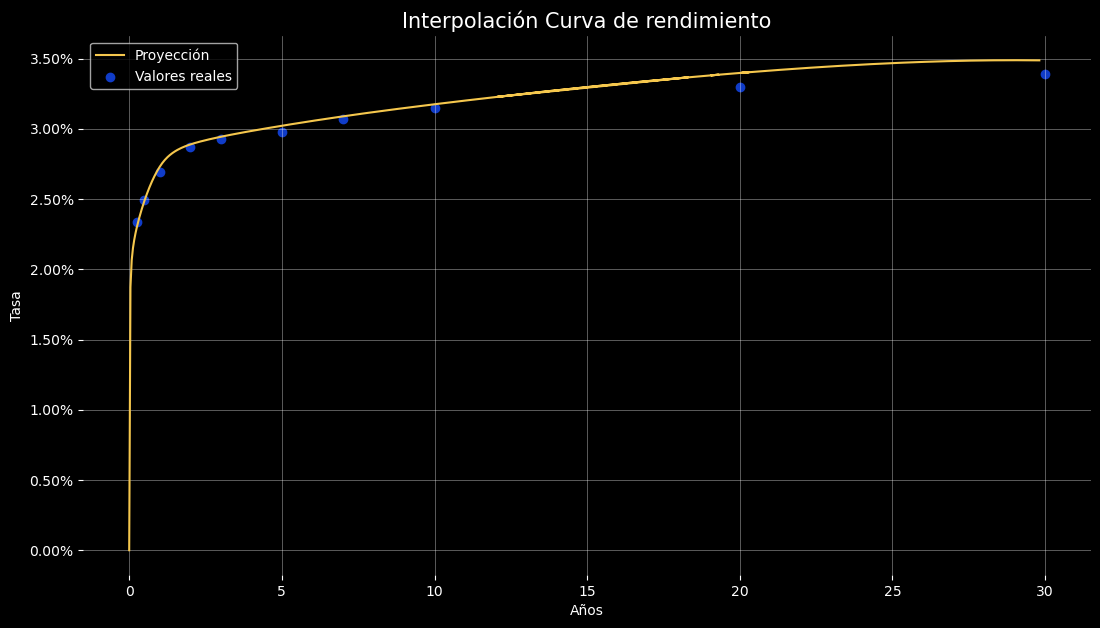

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as mtick

plt.style.use('dark_background')
fontsize=15
fig = plt.figure(figsize=(13,7))
ax = plt.axes()
ax.plot(disc_factor_graph.index, disc_factor_graph['Z rate'], c='#F5C74D', linestyle='-')



plt.scatter(yield_df['Maturity'], yield_df['Yield'], c='#103CC8', marker='o') #blue

# Configuración de la figura
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xlabel(f"Años")
plt.ylabel('Tasa')
plt.legend(['Proyección', 'Valores reales'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, linewidth=0.5, alpha=0.5)

plt.title("Interpolación Curva de rendimiento",fontsize=fontsize)
plt.show()

# Consideraciones Finales
# Los resultados son bastante sensibles a el espaciamiento entre los nudos a menos de que halla una distribución uniforme de bonos. 
# Por lo tanto es importante que los vencimientos de los bonos esten distribuidos de manera uniforme entre los bonos. 